- [x] try just one predictor
    - [ ] multi input, single output
- [x] comparem ulti
- losses:
    - try logp? nah
    - mae?
- [x] make my own csv with 5m data (maybe 10k rows)
- [ ] backtest?

In [1]:
import warnings
warnings.simplefilter("ignore")

# autoreload import your package
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import math
import logging
from typing import Callable, Optional, Union, Dict, Tuple

from matplotlib import pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors

import gin
from fire import Fire
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import nn

from experiments.base import Experiment
from data.datasets import ForecastDataset
from models import get_model
from utils.checkpoint import Checkpoint
from utils.ops import default_device, to_tensor
from utils.losses import get_loss_fn
from utils.metrics import calc_metrics

from experiments.forecast import get_data
gin.enter_interactive_mode()

In [3]:
import logging
logging.root.setLevel(logging.INFO)

from loguru import logger
logger.remove()
logger.add(os.sys.stdout, level="INFO", colorize=True, format="<level>{time} | {message}</level>")

1

# auto

In [4]:


def plot(model_name="deeptime", save_path=Path("storage/experiments/Exchange/96M/repeat=0"), i=200, title=None, plot=True):

    gin.clear_config()
    gin.parse_config(open(save_path/"config.gin"))

    train_set, train_loader = get_data(flag='train', batch_size=2)

    model = get_model(model_name,
                        dim_size=train_set.data_x.shape[1],
                        datetime_feats=train_set.timestamps.shape[-1]).to(default_device())
    model.load_state_dict(torch.load(save_path/'model.pth'))
    model = model.eval()


    b = train_set[i]
    b = [bb[None, :] for bb in b]
    b2 = list(map(to_tensor, b))
    context_past_x, context_y, query_past_x, query_y, context_time, query_time = b2
    with torch.no_grad():
        forecast = model(*b2)

    if title is None:
        title = str(save_path).split('/')[-3:]
        title = "-".join(title)
    
    colors = list(mcolors.BASE_COLORS.keys())
    l = x.shape[1]
    forecast2 = forecast[0].detach().cpu().numpy()
    x2 = x[0].cpu()
    y2 = y[0].cpu()
    l2 = y.shape[1]
    i_past = list(range(l))
    i_future = list(range(l, l+l2))
    
    if plot:
        plt.title(title)
        for i in range(x.shape[-1]):
            plt.plot(i_past, x2[:, i], c=colors[i])
        for i in range(x.shape[-1]):
            plt.plot(i_future, y2[:, i], c=colors[i])
        for i in range(x.shape[-1]):
            plt.plot(i_future, forecast2[:, i], c=colors[i], linestyle='--')
    return x2, y2, forecast2, i_past, i_future


In [5]:
list(mcolors.BASE_COLORS.keys())

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# view model

# run exps

In [6]:
# list the models we have run...
configs=sorted(Path("storage/experiments/Stocks").glob("**/config.gin"))
import random
random.shuffle(configs)
# print(configs)

In [7]:
from experiments.forecast import ForecastExperiment
from tqdm.auto import tqdm

In [8]:
# for config in tqdm(configs):
#     save_path = config.parent

#     exp = ForecastExperiment(config_path=config)
#     print(config)
#     try:
#         exp.run()
#     except KeyboardInterrupt:
#         raise
#     except Exception as e:
#         raise
#         print(e)
#         pass

In [9]:
# save_path = Path('storage/experiments/Stocks/96M2S/repeat=0')

In [10]:
# gin.clear_config()
# config_path = save_path/"config.gin"
# gin.parse_config(open(config_path))
# model_name = gin.query_parameter("instance.model_type")
# model_name

In [11]:

# exp = ForecastExperiment(config_path=config_path)
# # exp.run()

In [12]:
def save_path2name(save_path: Path) -> str:
    """
    Path('storage/experiments/Stocks/96M2S/base_learner=None,inr=INR,encoder=mlp,repeat=0')
    to 
    '96M2S-None_INR_mlp_0'
    """
    mtitle = str(save_path).split('/')[-2:]
    tags = mtitle[-1]
    tags = [x.split('=')[-1] for x in tags.split(',')]
    mtitle[-1] = '_'.join(tags)
    mtitle = "-".join(mtitle)
    return mtitle

# save_path2name(save_path)
# save_path

# view all

In [13]:
from torchsummaryX import summary
from torchinfo import summary

def plot_multi(save_paths=[Path("storage/experiments/Exchange/96M/repeat=0")], i=200, title=None, plot=True, verbose=1,):
    assert len(save_paths)>0
    for j in range(len(save_paths)):
        save_path = save_paths[j]

        gin.clear_config()
        gin.parse_config(open(save_path/"config.gin"))
        model_name = gin.query_parameter("instance.model_type")

        train_set, train_loader = get_data(flag='test', batch_size=3)
        seq_len = train_set[0][0].shape[0]
        model = get_model(model_name,
                            dim_size=train_set.data_x.shape[1],
                          seq_len=seq_len,
                            datetime_feats=train_set.timestamps.shape[-1]).to(default_device())
        model.load_state_dict(torch.load(save_path/'model.pth'))
        model = model.eval()
        
        


        b = train_set[i]
        b = [bb[None, :] for bb in b]
        b2 = list(map(to_tensor, b))
        
#         b = next(iter(train_loader))
#         print([s.shape for s in b]
        
        if verbose>1:
            print(summary(model, input_data=b2, depth=2))
            print(save_path)
        
        context_past_x, context_y, query_past_x, query_y, context_time, query_time = b2
        with torch.no_grad():
            forecast = model(*b2)
       
        colors = list(mcolors.BASE_COLORS.keys())
        l = context_time.shape[1]
        forecast2 = forecast[0].detach().cpu().numpy()
        x2 = context_y[0].cpu()
        y2 = query_y[0].cpu()
        l2 = query_time.shape[1]
        i_past = list(range(l))
        i_future = list(range(l, l+l2))

        if plot:
        
            if j==0:
                plt.plot(i_past, x2[:, 0], c=colors[0], label=f"past")
                plt.plot(i_future, y2[:, 0], c=colors[0], label="future true", alpha=0.3)
            mtitle = save_path2name(save_path)
            plt.plot(i_future, forecast2[:, 0], linestyle='--', label=f"{mtitle}") # c=colors[j], 
            

    plt.legend()
    plt.title(title)
    return x2, y2, forecast2, i_past, i_future


In [14]:
# list the models we have run...
m=sorted(Path("storage/experiments/Stocks/96M2S").glob("**/_SUCCESS"))
print(m)

[Path('storage/experiments/Stocks/96M2S/lrn=None,inr=INR,enc=lstm2,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=None,inr=INRPlus2,enc=inception,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Ridge,inr=INR,enc=inception,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Ridge,inr=INR,enc=mlp,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Ridge,inr=INRPlus2,enc=inception,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Ridge,inr=INRPlus2,enc=lstm2,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Transformer,inr=INR,enc=inception,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Transformer,inr=INR,enc=lstm2,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Transformer,inr=INRPlus2,enc=none,repeat=0/_SUCCESS'), Path('storage/experiments/Stocks/96M2S/lrn=Transformer,inr=INRPlus2,enc=transformer,repeat=0/_SUCCESS')]


In [15]:
# show score
for mm in m:
    mtitle = save_path2name(mm.parent)
#     print(mtitle)
    m3 = json.load((mm.parent/'metrics.json').open())
    m3 = eval(str(m3))
    print(f"mape={m3['val']['mape']:2.2f}, {mtitle}")

mape=3.13, 96M2S-None_INR_lstm2_0
mape=2.06, 96M2S-None_INRPlus2_inception_0
mape=1.41, 96M2S-Ridge_INR_inception_0
mape=1.83, 96M2S-Ridge_INR_mlp_0
mape=0.86, 96M2S-Ridge_INRPlus2_inception_0
mape=0.84, 96M2S-Ridge_INRPlus2_lstm2_0
mape=1.76, 96M2S-Transformer_INR_inception_0
mape=2.39, 96M2S-Transformer_INR_lstm2_0
mape=1.89, 96M2S-Transformer_INRPlus2_none_0
mape=1.94, 96M2S-Transformer_INRPlus2_transformer_0


In [16]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# show size
save_paths = [mm.parent for mm in m]
for mm in m:
    try:
        plot_multi(
            save_paths=[mm.parent],
            i=600,
            verbose=2,
        )
    except Exception as e:
        print('failed', mm, e)
#         mm.unlink()
        pass
1

In [ ]:
save_paths = [mm.parent for mm in m]
plot_multi(
    save_paths=save_paths,
    i=200,
    verbose=0,
)
1

In [ ]:
256/24

# check positions in dl

In [83]:
train_set, train_loader = get_data(flag='test', batch_size=3)
b = context_past_x, context_y, query_past_x, query_y, context_time, query_time = train_set[0]
print([bb.shape for bb in b])
# context_y, query_y

[(138, 5), (46, 1), (138, 5), (46, 1), (46, 0), (46, 0)]


In [84]:
cx_start, cx_end, c_start, c_end, qx_start, qx_end, q_start, q_end = train_set.get_inds(0)
cx_start, cx_end, c_start, c_end, qx_start, qx_end, q_start, q_end

(0, 138, 138, 184, 46, 184, 184, 230)

In [89]:
plt.vlines

<function matplotlib.pyplot.vlines(x, ymin, ymax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)>

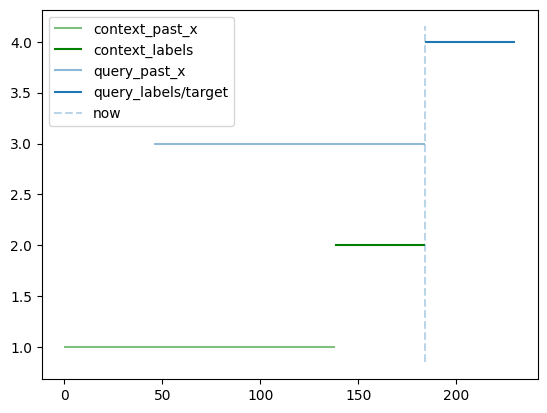

In [94]:
plt.hlines(1, cx_start, cx_end, color='green', alpha=0.5, label='context_past_x')
plt.hlines(2, c_start, c_end, color='green', label='context_labels')
plt.hlines(3, qx_start, qx_end, alpha=0.5, label='query_past_x')
plt.hlines(4, q_start, q_end, label='query_labels/target')
o = train_set.horizon_len+train_set.lookback_len
plt.vlines(o, *plt.ylim(), alpha=0.3, ls='--', label='now')
plt.legend(loc='upper left')

# backtest

In [17]:
save_path = Path('storage/experiments/Stocks/96M2S/lrn=Ridge,inr=INRPlus2,enc=lstm2,repeat=0')

In [22]:
gin.clear_config()
gin.parse_config(open(save_path/"config.gin"))
model_name = gin.query_parameter("instance.model_type")

train_set, train_loader = get_data(flag='train', batch_size=256)
test_set, test_loader = get_data(flag='test', batch_size=256)
seq_len = train_set[0][0].shape[0]
model = get_model(model_name,
                    dim_size=train_set.data_x.shape[1],
                  seq_len=seq_len,
                    datetime_feats=train_set.timestamps.shape[-1]).to(default_device())
model.load_state_dict(torch.load(save_path/'model.pth'))
model = model.eval()


receptive field [690 378 242]


In [117]:
test_set, test_loader = get_data(flag='test', batch_size=256)
test_set.index

42765    2020-09-01 16:10:00
42766    2020-09-01 16:20:00
42767    2020-09-01 16:35:00
42768    2020-09-01 16:40:00
42769    2020-09-01 16:45:00
                ...         
53256    2020-12-30 15:30:00
53257    2020-12-30 15:35:00
53258    2020-12-30 15:40:00
53259    2020-12-30 15:45:00
53260    2020-12-30 15:50:00
Name: date, Length: 10496, dtype: object

10496

In [45]:
def pred(test_loader, model):
    isinstance(test_loader.sampler, torch.utils.data.sampler.SequentialSampler)
    forecasts = []
    with torch.no_grad():
        for it, data in enumerate(tqdm(test_loader)):
            data2 = list(map(to_tensor, data))
            context_past_x, context_y, query_past_x, query_y, context_time, query_time  = data2

            if context_past_x.shape[0] == 1:
                # skip final batch if batch_size == 1
                # due to bug in torch.linalg.solve which raises error when batch_size == 1
                continue

            forecast = model(*data2)
            forecasts.append(forecast.cpu().numpy())
    return np.concatenate(forecasts, 0)

In [131]:
import pandas as pd
df = pd.read_csv(Path('storage/datasets')/test_loader.dataset.data_path).set_index('date')
close = df.close.reindex(test_set.index)
close

date
2020-09-01 16:10:00    12.480
2020-09-01 16:20:00    12.480
2020-09-01 16:35:00    12.500
2020-09-01 16:40:00    12.500
2020-09-01 16:45:00    12.500
                        ...  
2020-12-30 15:30:00    17.845
2020-12-30 15:35:00    17.875
2020-12-30 15:40:00    17.840
2020-12-30 15:45:00    17.800
2020-12-30 15:50:00    17.895
Name: close, Length: 10496, dtype: float64

In [133]:
y_pred = pred(test_loader, model)[:, :, 0]
y_pred

  0%|          | 0/41 [00:00<?, ?it/s]

array([[-0.6328174 , -0.63319993, -0.6346327 , ..., -0.5592192 ,
        -0.55776495, -0.5553882 ],
       [-0.63254887, -0.6316724 , -0.6318742 , ..., -0.55676687,
        -0.55493146, -0.55278534],
       [-0.6345463 , -0.6336551 , -0.6358172 , ..., -0.54483443,
        -0.54275066, -0.54060847],
       ...,
       [ 0.5262324 ,  0.5326949 ,  0.5357634 , ...,  0.6983865 ,
         0.7018202 ,  0.70224243],
       [ 0.53653884,  0.54718244,  0.5533827 , ...,  0.7077196 ,
         0.7094669 ,  0.7116887 ],
       [ 0.539682  ,  0.5489382 ,  0.5567719 , ...,  0.6913836 ,
         0.6931053 ,  0.6938973 ]], dtype=float32)

In [135]:
import vectorbt as vbt
pf = vbt.Portfolio.from_signals(
    close,
    entries=entries,
    exits=exits,
    short_entries=short_entries,
    short_exits=short_exits,
    fees=fees,
    freq="5T",
    size=size # size=1 and short leas to inf's
)

ModuleNotFoundError: No module named 'vectorbt'